# Config

In [1]:
__author__ = "Elliot Simon"
__email__ = "ellsim@dtu.dk"
__date__ = "November 23, 2020"
__credits__ = ["DTU Wind Energy", "IFREMER", "Marc Le Boulluec", "Freddy J. Madsen"]
__license__ = "GNU GPL v3.0"

In [2]:
'''The Purpose of the software is to process and quality control measurement data from the MARINET2 round-robbin experiment 
involving DTU Wind Energy & IFREMER in December 2019.
Please direct questions to {0}'''.format(__email__)

'The Purpose of the software is to process and quality control measurement data from the MARINET2 round-robbin experiment \ninvolving DTU Wind Energy & IFREMER in December 2019.\nPlease direct questions to ellsim@dtu.dk'

In [3]:
# Need to cite in published dataset:
# Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package. J. Stat. Soft., 31 (2009) 
# doi:10.18637/jss.v031.i07.

In [4]:
#import required modules

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime
import sys

In [5]:
# set plotting preferences

%matplotlib inline
#%matplotlib notebook

plt.style.use('classic')
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.formatter.useoffset'] = False

fmt = DateFormatter('%D %H:%M:%S')

In [6]:
# paths to data files from IFREMER and DTU acquisition systems

path_ifremer = './/DTU_093//DTU_093.txt'
path_dtu = './/DTU_093//dtupc_093'

In [7]:
filename = path_ifremer.split('//')[1]
print(filename)

DTU_093


# IFREMER data

## Load & process data

In [8]:
%%time
# read TSV txt file from IFREMER
# skip first 7 rows which are metadata
# force strip non-unicode characters

df_ifremer = pd.read_csv(path_ifremer, delimiter='\t', header=0, index_col=0, 
                         skiprows=7, encoding = 'unicode_escape')

Wall time: 2.29 s


<decorator-gen-62>:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.


In [9]:
# drop rows between header and first data point
# drop last column which is empty

df_ifremer = df_ifremer.iloc[4:, :-1]

In [10]:
# convert dtypes to numerics now that the rows with strings are dropped
df_ifremer = df_ifremer.apply(pd.to_numeric)

# force index to numeric
df_ifremer.index = pd.to_numeric(df_ifremer.index, errors='raise')

In [11]:
# convert index to TimeDeltaIndex
df_ifremer.index = pd.to_timedelta(df_ifremer.index, unit='s')

# rename index
df_ifremer.index.rename('Time', inplace=True)

In [12]:
df_ifremer.index

TimedeltaIndex([       '00:00:00', '00:00:00.010000', '00:00:00.020000',
                '00:00:00.030000', '00:00:00.040000', '00:00:00.050000',
                '00:00:00.060000', '00:00:00.070000', '00:00:00.080000',
                '00:00:00.090000',
                ...
                '00:15:26.780000', '00:15:26.790000', '00:15:26.800000',
                '00:15:26.810000', '00:15:26.820000', '00:15:26.830000',
                '00:15:26.840000', '00:15:26.850000', '00:15:26.860000',
                '00:15:26.870000'],
               dtype='timedelta64[ns]', name='Time', length=92688, freq=None)

In [13]:
# Check intervals on IFREMER data. Should only have 1 value i.e. consistant sampling
print(np.unique(np.diff(df_ifremer.index.values)))

[10000000]


In [14]:
df_ifremer.dtypes

Proue Tribord (s)    float64
Proue Babord (p)     float64
Poupe (m)            float64
Surge_gauge          float64
Side_gauge           float64
Accelerometer        float64
Wave_43m5            float64
Wave_31m5            float64
Wave_25m             float64
Consigne             float64
Verin_ouest          float64
Verin_est            float64
Cobra1               float64
Cobra2               float64
Cobra3               float64
Cobra4               float64
WMPro_U              float64
WMPro_V              float64
WMPro_W              float64
DTU X                float64
DTU Y                float64
DTU Z                float64
DTU Yaw              float64
DTU Pitch            float64
DTU Roll             float64
DTU Residual         float64
dtype: object

In [15]:
df_ifremer.index.dtype

dtype('<m8[ns]')

In [16]:
# Subtract mean from wave measurement to remove offset
df_ifremer['Wave_25m'] = (df_ifremer['Wave_25m'] - df_ifremer['Wave_25m'].mean())
df_ifremer['Wave_31m5'] = (df_ifremer['Wave_31m5'] - df_ifremer['Wave_31m5'].mean())
df_ifremer['Wave_43m5'] = (df_ifremer['Wave_43m5'] - df_ifremer['Wave_43m5'].mean())

In [17]:
# inspect resulting dataframe
df_ifremer.head()

,Proue Tribord (s),Proue Babord (p),Poupe (m),Surge_gauge,Side_gauge,Accelerometer,Wave_43m5,Wave_31m5,Wave_25m,Consigne,...,WMPro_U,WMPro_V,WMPro_W,DTU X,DTU Y,DTU Z,DTU Yaw,DTU Pitch,DTU Roll,DTU Residual
Time,,,,,,,,,,,,,,,,,,,,,
00:00:00,15.701026,0.124885,2.871793,0.054326,0.899108,12.809622,-0.234070,0.353412,-11.696763,0.061431,...,1.222299,0.007824,0.036740,502.04019,-28.93543,-201.98926,-0.11491,-0.00981,-0.03213,0.15693
00:00:00.010000,15.607521,0.289263,2.988681,0.810518,-0.503478,12.341154,0.499807,1.615850,-1.225329,0.041058,...,-0.000062,-0.028978,0.015710,502.16703,-28.54573,-201.87712,-0.11922,-0.01953,-0.01353,0.15315
00:00:00.020000,15.565393,0.269810,3.054105,0.657327,-0.378856,12.482121,0.470452,1.234182,-0.902680,0.115977,...,-0.004005,-0.056580,-0.009263,502.16118,-28.58303,-201.92183,-0.11849,-0.01820,-0.01947,0.14059
00:00:00.030000,15.662802,0.354430,3.026602,-0.333157,-0.017372,12.337119,-0.351491,-1.143898,-0.404040,-0.012502,...,0.002566,-0.046065,0.006510,502.10467,-28.60567,-201.95740,-0.11703,-0.01457,-0.02129,0.16209
00:00:00.040000,15.617797,0.294126,3.047646,0.368217,-0.679963,12.469543,-1.056012,-1.437489,-1.195997,0.037115,...,0.014396,-0.042122,-0.004005,502.13882,-28.72425,-202.00876,-0.12222,-0.01228,-0.03254,0.16534


### Ensure that columns of IFREMER data have not changed from template

In [18]:
# Check column names and order
IFREMER_french_column_names = str(df_ifremer.columns)
print(IFREMER_french_column_names)

Index(['Proue Tribord (s)', 'Proue Babord (p)', 'Poupe (m)', 'Surge_gauge',
       'Side_gauge', 'Accelerometer', 'Wave_43m5', 'Wave_31m5', 'Wave_25m',
       'Consigne', 'Verin_ouest', 'Verin_est', 'Cobra1', 'Cobra2', 'Cobra3',
       'Cobra4', 'WMPro_U', 'WMPro_V', 'WMPro_W', 'DTU X', 'DTU Y', 'DTU Z',
       'DTU Yaw', 'DTU Pitch', 'DTU Roll', 'DTU Residual'],
      dtype='object')


In [ ]:
# Only run this once for generating column template

# Open file for writing column names
file_col_names_ifremer = open(".//IFREMER_french_column_names.txt","w+")
# Write column names in French
file_col_names_ifremer.write(IFREMER_french_column_names)
# Close file pointer
file_col_names_ifremer.close()

In [19]:
# Run this cell each time a file is processed

# Open file for reading column names
file_col_names_ifremer = open(".//IFREMER_french_column_names.txt","r")
# Read column names in French
file_col_names_ifremer_template = file_col_names_ifremer.read()
# Close file pointer
file_col_names_ifremer.close()

In [20]:
# Check that columns in loaded file match known column template
if (file_col_names_ifremer_template == IFREMER_french_column_names):
    print('Success! IFREMER column names (in French) match template.')
else:
    print('Error!! IFREMER column names(in French) do not match template. Check input file.')
    sys.exit()

Success! IFREMER column names (in French) match template.


## Rename IFREMER column names to English

In [21]:
# Now that we're sure channel names and order are consistant, then translate them to English

df_ifremer.columns = ['Mooring_starbord', 'Mooring_port', 'Mooring_aft', 'Surge_gauge', 'Side_gauge', 
                      'Accelerometer', 'Wave_43m5', 'Wave_31m5', 'Wave_25m', 'Wave_paddle', 'Jack_west', 
                      'Jack_east', 'Cobra1', 'Cobra2', 'Cobra3', 'Cobra4', 'WMPro_U', 'WMPro_V', 'WMPro_W', 
                      'DTU X', 'DTU Y', 'DTU Z', 'DTU Yaw', 'DTU Pitch', 'DTU Roll', 'DTU Residual']

In [22]:
df_ifremer.head()

,Mooring_starbord,Mooring_port,Mooring_aft,Surge_gauge,Side_gauge,Accelerometer,Wave_43m5,Wave_31m5,Wave_25m,Wave_paddle,...,WMPro_U,WMPro_V,WMPro_W,DTU X,DTU Y,DTU Z,DTU Yaw,DTU Pitch,DTU Roll,DTU Residual
Time,,,,,,,,,,,,,,,,,,,,,
00:00:00,15.701026,0.124885,2.871793,0.054326,0.899108,12.809622,-0.234070,0.353412,-11.696763,0.061431,...,1.222299,0.007824,0.036740,502.04019,-28.93543,-201.98926,-0.11491,-0.00981,-0.03213,0.15693
00:00:00.010000,15.607521,0.289263,2.988681,0.810518,-0.503478,12.341154,0.499807,1.615850,-1.225329,0.041058,...,-0.000062,-0.028978,0.015710,502.16703,-28.54573,-201.87712,-0.11922,-0.01953,-0.01353,0.15315
00:00:00.020000,15.565393,0.269810,3.054105,0.657327,-0.378856,12.482121,0.470452,1.234182,-0.902680,0.115977,...,-0.004005,-0.056580,-0.009263,502.16118,-28.58303,-201.92183,-0.11849,-0.01820,-0.01947,0.14059
00:00:00.030000,15.662802,0.354430,3.026602,-0.333157,-0.017372,12.337119,-0.351491,-1.143898,-0.404040,-0.012502,...,0.002566,-0.046065,0.006510,502.10467,-28.60567,-201.95740,-0.11703,-0.01457,-0.02129,0.16209
00:00:00.040000,15.617797,0.294126,3.047646,0.368217,-0.679963,12.469543,-1.056012,-1.437489,-1.195997,0.037115,...,0.014396,-0.042122,-0.004005,502.13882,-28.72425,-202.00876,-0.12222,-0.01228,-0.03254,0.16534


# DTU Data

## Load and process data

In [23]:
%%time
# read TSV txt file from DTU
# force comma decimal marker (instead of period)
# force strip non-unicode characters

df_dtu = pd.read_csv(path_dtu, delimiter='\t', header=0, index_col=0, decimal=',', 
                         encoding = 'unicode_escape')

Wall time: 1.46 s


In [24]:
# Concat used columns and drop unused ones
# Column 20 = sonic u-component
# Column 36 = wave elevation at 31.5m

df_dtu = pd.concat([(df_dtu.iloc[:,0].rename('GenVelocity')), df_dtu.iloc[:,1:3], 
                    (df_dtu.iloc[:,20].rename('Sonic_U')), (df_dtu.iloc[:,36].rename('Wave_elev_31_5m'))], axis=1)

df_dtu.index.rename('Time', inplace=True)

In [25]:
df_dtu.head()

,GenVelocity,GenTorque,BladePitch,Sonic_U,Wave_elev_31_5m
Time,,,,,
12.88,4.953,0.286,11.391,0.328,4.806
12.90,4.953,0.286,11.381,0.322,4.806
12.92,5.113,0.287,11.376,0.327,4.796
12.94,5.113,0.288,11.370,0.325,4.814
12.96,4.953,0.288,11.360,0.299,4.784


In [26]:
# Convert float index to TimeDeltaIndex
df_dtu.index = pd.to_timedelta(df_dtu.index, unit='s')

In [27]:
# Apply known calibration corrections

# Gear ratio = 5 (multiply by GenVelocity)
gear_ratio = 5
# Offset pitch = +6 (subtract from BladePitch)
offset_pitch = 6
# Calibration gain of sonic 
sonic_gain = 4
# Calibration gain of wave height
wave_gain = -89.265

# Correct BladePitch values by offset pitch
df_dtu['BladePitch'] = df_dtu['BladePitch'] - offset_pitch

# Apply gain to sonic U
df_dtu['Sonic_U'] = df_dtu['Sonic_U'] * sonic_gain

# Subtract mean and apply gain to wave elevation
df_dtu['Wave_elev_31_5m'] = (df_dtu['Wave_elev_31_5m'] - df_dtu['Wave_elev_31_5m'].mean()) * wave_gain

In [28]:
# Make new derived column Rotational Speed (in RPM)
df_dtu['RotSpeed']= df_dtu['GenVelocity'] * (60/(2*np.pi)) * gear_ratio

In [29]:
df_dtu.head()

,GenVelocity,GenTorque,BladePitch,Sonic_U,Wave_elev_31_5m,RotSpeed
Time,,,,,,
00:00:12.880000,4.953,0.286,5.391,1.312,-0.731265,236.488330
00:00:12.900000,4.953,0.286,5.381,1.288,-0.731265,236.488330
00:00:12.920000,5.113,0.287,5.376,1.308,0.161385,244.127767
00:00:12.940000,5.113,0.288,5.370,1.300,-1.445385,244.127767
00:00:12.960000,4.953,0.288,5.360,1.196,1.232565,236.488330


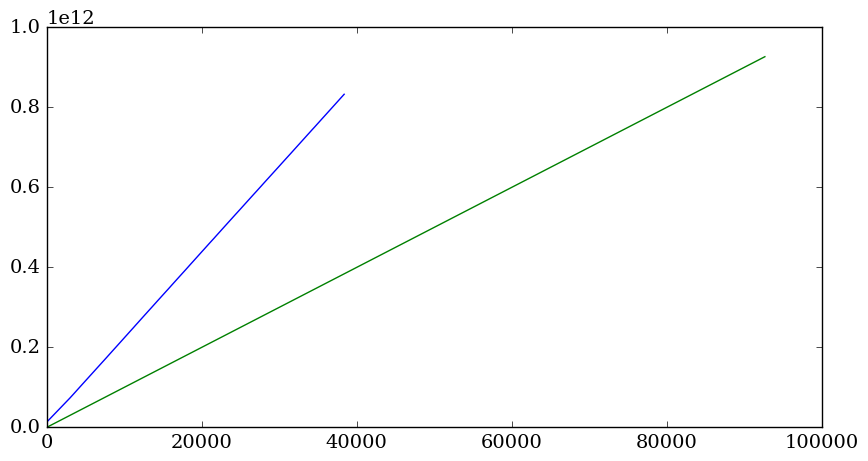

In [30]:
# Check index ordering
plt.plot(df_dtu.index.values)
plt.plot(df_ifremer.index.values)

In [31]:
# Subtract starting time to ensure DTU index begins at 0.0
df_dtu.index = df_dtu.index - df_dtu.index[0]

In [32]:
df_dtu.index

TimedeltaIndex([       '00:00:00', '00:00:00.020000', '00:00:00.040000',
                '00:00:00.060000', '00:00:00.080000', '00:00:00.100000',
                '00:00:00.120000', '00:00:00.140000', '00:00:00.160000',
                '00:00:00.180000',
                ...
                '00:13:39.880000', '00:13:39.900000', '00:13:39.920000',
                '00:13:39.940000', '00:13:39.960000', '00:13:39.980000',
                       '00:13:40', '00:13:40.020000', '00:13:40.040000',
                '00:13:40.080000'],
               dtype='timedelta64[ns]', name='Time', length=38402, freq=None)

{numpy.timedelta64(20000000,'ns'), numpy.timedelta64(40000000,'ns')}
Warning! Indices are not consistantly separated.


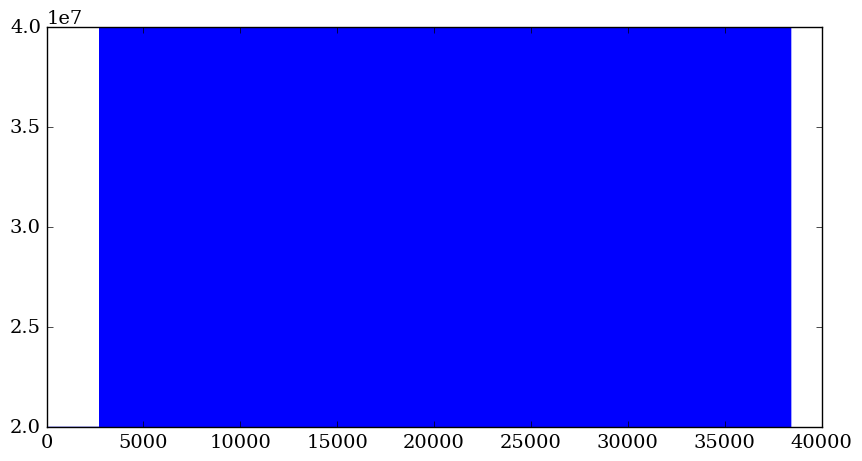

In [33]:
# Check timesteps are consistent
sample_rate = np.unique(np.diff(df_dtu.index.values))
n_unique_sample_rate = set(sample_rate)
print(n_unique_sample_rate)
if len(n_unique_sample_rate) != 1:
    print("Warning! Indices are not consistantly separated.")
plt.plot(np.diff(df_dtu.index.values))
#plt.hist(np.diff(df_dtu.index.microseconds.values), bins=100);

In [34]:
# Check number of NaNs
np.isnan(df_dtu).sum()

GenVelocity        0
GenTorque          0
BladePitch         0
Sonic_U            0
Wave_elev_31_5m    0
RotSpeed           0
dtype: int64

In [35]:
# Align index of DTU data (50 Hz) to IFREMER data (100 Hz)

print('Duration of lab test (IFREMER data logging reference) = ')
print(df_ifremer.last_valid_index()-df_ifremer.first_valid_index())
# Apply new index to prepare for interpolation
#df_dtu = df_dtu.reindex(df_ifremer.index)
df_dtu = df_dtu.reindex(df_dtu.index.union(df_ifremer.index))

Duration of lab test (IFREMER data logging reference) = 
0 days 00:15:26.870000


In [36]:
df_dtu.index

TimedeltaIndex([       '00:00:00', '00:00:00.010000', '00:00:00.020000',
                '00:00:00.030000', '00:00:00.040000', '00:00:00.050000',
                '00:00:00.060000', '00:00:00.070000', '00:00:00.080000',
                '00:00:00.090000',
                ...
                '00:15:26.780000', '00:15:26.790000', '00:15:26.800000',
                '00:15:26.810000', '00:15:26.820000', '00:15:26.830000',
                '00:15:26.840000', '00:15:26.850000', '00:15:26.860000',
                '00:15:26.870000'],
               dtype='timedelta64[ns]', name='Time', length=92688, freq='10L')

In [37]:
# Interpolate to fill NaNs. Only done inside (i.e. no extrapolation)
df_dtu = df_dtu.interpolate(method='time', limit=3, limit_area='inside')

In [38]:
df_dtu.shape

(92688, 6)

In [39]:
# Ensure sampling rate is consistant and matches target
set(np.diff(df_dtu.index))

{numpy.timedelta64(10000000,'ns')}

In [40]:
df_dtu.head()

,GenVelocity,GenTorque,BladePitch,Sonic_U,Wave_elev_31_5m,RotSpeed
Time,,,,,,
00:00:00,4.953,0.2860,5.3910,1.312,-0.731265,236.488330
00:00:00.010000,4.953,0.2860,5.3860,1.300,-0.731265,236.488330
00:00:00.020000,4.953,0.2860,5.3810,1.288,-0.731265,236.488330
00:00:00.030000,5.033,0.2865,5.3785,1.298,-0.284940,240.308049
00:00:00.040000,5.113,0.2870,5.3760,1.308,0.161385,244.127767


In [41]:
# Ensure indices are identical
(df_dtu.index==df_ifremer.index).all()

True

In [42]:
# Re-check number of NaNs
np.isnan(df_dtu).sum()

GenVelocity        10679
GenTorque          10679
BladePitch         10679
Sonic_U            10679
Wave_elev_31_5m    10679
RotSpeed           10679
dtype: int64

In [43]:
df_dtu.shape

(92688, 6)

## Try stretching index values

In [ ]:
dtu_index_backup = df_dtu.index
ifremer_index_backup = df_ifremer.index

In [ ]:
df_dtu.index = dtu_index_backup
df_ifremer.index = ifremer_index_backup

In [ ]:
# Put them both back into float indices (from datetime)
df_dtu.set_index((df_dtu.index.total_seconds()), inplace=True)
df_ifremer.set_index(df_ifremer.index.total_seconds(), inplace=True)

In [ ]:
# index linspaced stretch
df_dtu.index = df_dtu.index * 0.984

In [ ]:
# idnex offset
df_dtu.index = df_dtu.index + 7.49 + 0.75 + 0.4

In [ ]:
df_dtu.index

In [ ]:
(df_all_inner['Wave_elev_31_5m']+100).plot(c='g', label='dtu')
#no shift
df_all_inner['Wave_31m5'].plot(c='b', label='ifremer')
plt.legend(fontsize=7)
#plt.gcf().autofmt_xdate()

#(df_dtu['Wave_elev_25m'].shift(shift)).plot(c='g')
#df_ifremer['Wave_25m'].plot()

# Cross-correlation and time sync

In [44]:
# Functions for performing cross-correlation between two time-series signals

def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

def plotxcorr(a,b, lower=-1000, upper=1000):
    '''
    Calculate cross-correlation between two time series signals for given range of lags.
    Inputs: a,b are pandas.Series. lower,upper are optional integers.
    Returns: cross-correlation peak value and lag index. Plots the cross-correlation function and peak location.
    '''
    xcorr = [crosscorr(a, b, lag=i) for i in range(lower,upper,1)]
    peak = np.argmax(xcorr) + lower
    peak_val = str(max(xcorr))[0:5]

    f, ax = plt.subplots()
    mins = np.arange(lower,upper,1).tolist()
    plt.plot(mins, xcorr)
    plt.axvline(peak, c='g')
    return peak, float(peak_val)

In [45]:
# Moving average to remove noise for cross correlation
df_roll = pd.concat([df_dtu['Sonic_U'], df_ifremer['WMPro_U']], axis=1)

print(np.isnan(df_roll).sum())
df_roll = df_roll.rolling(20).mean()
df_roll = df_roll.iloc[::20]

Wind signal correlation peak = 0.673 at index -4555
Wave signal correlation peak = 0.299 at index -4538
Wall time: 57.3 s


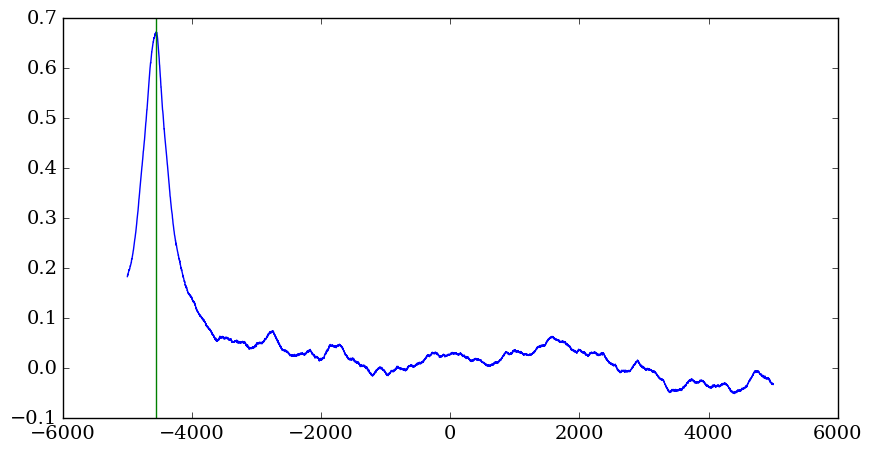

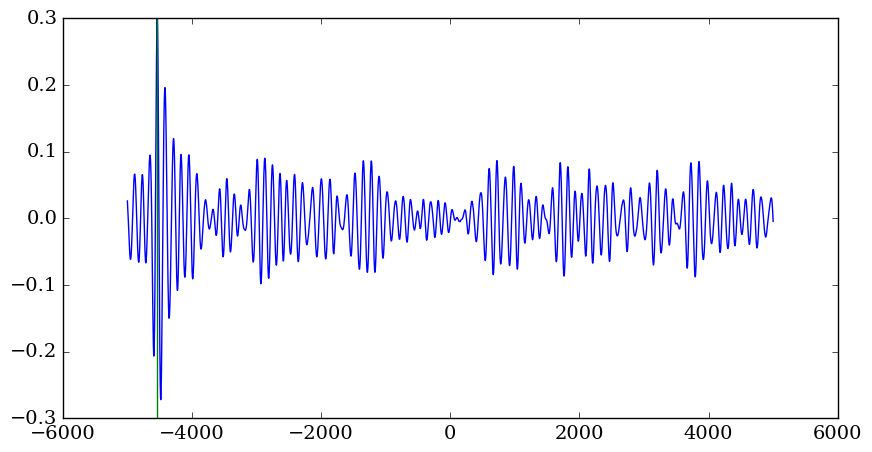

In [45]:
%%time
# Calculate cross-correlation of lags between DTU and IFREMER data acquisition
# Units are in 10 milliseconds
# This is the delta in start time between the two systems. The turbine control starts when wind speed
# is above cut in. Maximum should be around 60s (6000 index) and normally in the negative direction

xcorr_peak_wind, xcorr_val_wind = plotxcorr(df_dtu['Sonic_U'], df_ifremer['WMPro_U'], lower=-5000, upper=5000)
print('Wind signal correlation peak = {0} at index {1}'.format(xcorr_val_wind, xcorr_peak_wind))
xcorr_peak_wave, xcorr_val_wave = plotxcorr(df_dtu['Wave_elev_31_5m'], df_ifremer['Wave_31m5'], lower=-5000, upper=5000)
print('Wave signal correlation peak = {0} at index {1}'.format(xcorr_val_wave, xcorr_peak_wave))

In [46]:
# Time-sync logic. Compares xcorr result for both wind & wave and uses the better result for index shifting.

# Check if correlation value is too low on either signal
if max(xcorr_val_wind, xcorr_val_wave) < 0.5:
    print('Error!! The correlation between DTU & IFRAMER data is too damn low!')
    sys.exit()
else:
    # Check which signal has a higher correlation (i.e. if wind only or wave only test)
    if xcorr_val_wind > xcorr_val_wave:
        print('Wind correlation is stronger')
        print('shifting by {0} seconds'.format(xcorr_peak_wind/100))
        # shift by xcorr_peak_wind
        #df_dtu.index = df_dtu.index + pd.Timedelta(-(xcorr_peak_wind/100), unit='s')
        df_dtu = df_dtu.shift(freq = pd.Timedelta(-(xcorr_peak_wind/100), unit='s'))
    else:
        print('Wave correlation is stronger')
        # also catches cases where the two correlations are identical
        print('shifting by {0} seconds'.format(xcorr_peak_wave/100))
        # shift by xcorr_peak_wave
        #df_dtu.index = df_dtu.index + pd.Timedelta(-(xcorr_peak_wave/100), unit='s')
        df_dtu = df_dtu.shift(freq = pd.Timedelta(-(xcorr_peak_wave/100), unit='s'))

Wind correlation is stronger
shifting by -45.55 seconds


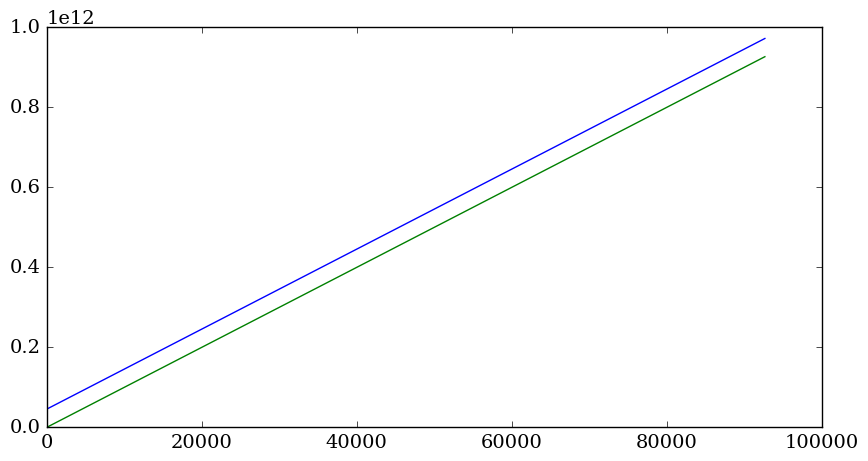

In [47]:
# Check shift result on index
plt.plot(df_dtu.index)
plt.plot(df_ifremer.index)

In [48]:
# Join the shifted DTU data and IFREMER data on IFREMER index. Fill NaNs on the shifted DTU data

df_all = df_ifremer.join(df_dtu, on=df_ifremer.index, how='left')

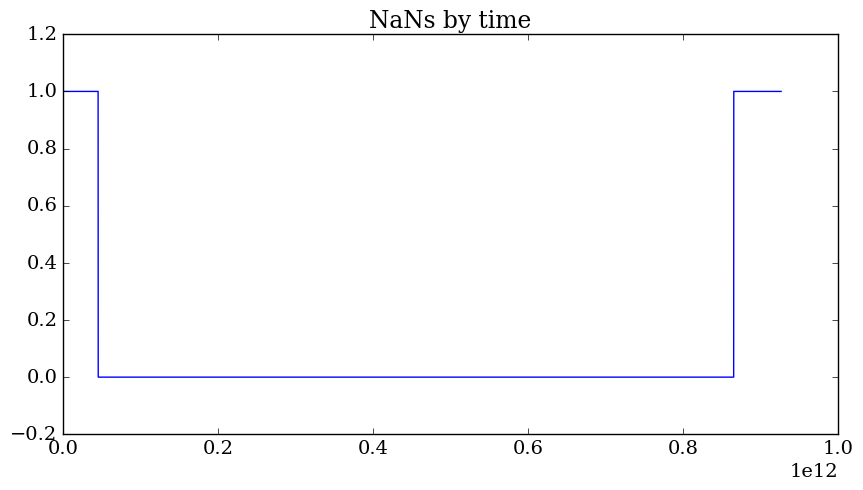

In [49]:
# Check NaNs across the combined index
plt.plot(np.isnan(df_all['Sonic_U']))
plt.ylim(-0.2,1.2)
plt.title('NaNs by time');

In [50]:
df_all.head()

,Mooring_starbord,Mooring_port,Mooring_aft,Surge_gauge,Side_gauge,Accelerometer,Wave_43m5,Wave_31m5,Wave_25m,Wave_paddle,...,DTU Yaw,DTU Pitch,DTU Roll,DTU Residual,GenVelocity,GenTorque,BladePitch,Sonic_U,Wave_elev_31_5m,RotSpeed
Time,,,,,,,,,,,,,,,,,,,,,
00:00:00,15.701026,0.124885,2.871793,0.054326,0.899108,12.809622,-0.234070,0.353412,-11.696763,0.061431,...,-0.11491,-0.00981,-0.03213,0.15693,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.010000,15.607521,0.289263,2.988681,0.810518,-0.503478,12.341154,0.499807,1.615850,-1.225329,0.041058,...,-0.11922,-0.01953,-0.01353,0.15315,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.020000,15.565393,0.269810,3.054105,0.657327,-0.378856,12.482121,0.470452,1.234182,-0.902680,0.115977,...,-0.11849,-0.01820,-0.01947,0.14059,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.030000,15.662802,0.354430,3.026602,-0.333157,-0.017372,12.337119,-0.351491,-1.143898,-0.404040,-0.012502,...,-0.11703,-0.01457,-0.02129,0.16209,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.040000,15.617797,0.294126,3.047646,0.368217,-0.679963,12.469543,-1.056012,-1.437489,-1.195997,0.037115,...,-0.12222,-0.01228,-0.03254,0.16534,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df_all.shape

(92688, 32)

In [52]:
np.isnan(df_all).sum()

Mooring_starbord        0
Mooring_port            0
Mooring_aft             0
Surge_gauge             0
Side_gauge              0
Accelerometer           0
Wave_43m5               0
Wave_31m5               0
Wave_25m                0
Wave_paddle             0
Jack_west               0
Jack_east               0
Cobra1                  0
Cobra2                  0
Cobra3                  0
Cobra4                  0
WMPro_U                 0
WMPro_V                 0
WMPro_W                 0
DTU X                   0
DTU Y                   0
DTU Z                   0
DTU Yaw                 0
DTU Pitch               0
DTU Roll                0
DTU Residual            0
GenVelocity         10679
GenTorque           10679
BladePitch          10679
Sonic_U             10679
Wave_elev_31_5m     10679
RotSpeed            10679
dtype: int64

In [53]:
# Do inner join (i.e. drop NaN rows) to get only period where both systems are measuring
# Some functions don't play well with missing data.
df_all_inner = df_all.dropna(how='any')

In [54]:
df_all_inner.head()

,Mooring_starbord,Mooring_port,Mooring_aft,Surge_gauge,Side_gauge,Accelerometer,Wave_43m5,Wave_31m5,Wave_25m,Wave_paddle,...,DTU Yaw,DTU Pitch,DTU Roll,DTU Residual,GenVelocity,GenTorque,BladePitch,Sonic_U,Wave_elev_31_5m,RotSpeed
Time,,,,,,,,,,,,,,,,,,,,,
00:00:45.550000,16.180264,0.826165,1.964817,4.617012,-0.734921,12.851628,0.940133,-1.231975,-0.521367,0.005899,...,-0.31951,-2.40192,-0.01065,0.23012,4.953,0.2860,5.3910,1.312,-0.731265,236.488330
00:00:45.560000,16.168345,0.826894,1.936689,4.309879,-0.015824,12.806300,-3.580549,-6.898266,3.438419,-0.089721,...,-0.32426,-2.41036,0.00572,0.22026,4.953,0.2860,5.3860,1.300,-0.731265,236.488330
00:00:45.570000,16.140191,0.634553,1.918978,4.438289,-0.732598,12.751479,-4.696042,0.558925,-2.017286,0.044673,...,-0.32543,-2.41571,0.01283,0.22522,4.953,0.2860,5.3810,1.288,-0.731265,236.488330
00:00:45.580000,16.170605,0.799660,1.932938,4.903869,0.234196,13.148040,0.000770,0.676361,0.475913,0.044673,...,-0.32411,-2.40696,0.00071,0.22732,5.033,0.2865,5.3785,1.298,-0.284940,240.308049
00:00:45.590000,16.200815,0.818383,1.945440,5.559436,0.760553,13.170822,-1.760534,-2.964158,0.446581,-0.032875,...,-0.32683,-2.41683,0.01932,0.26010,5.113,0.2870,5.3760,1.308,0.161385,244.127767


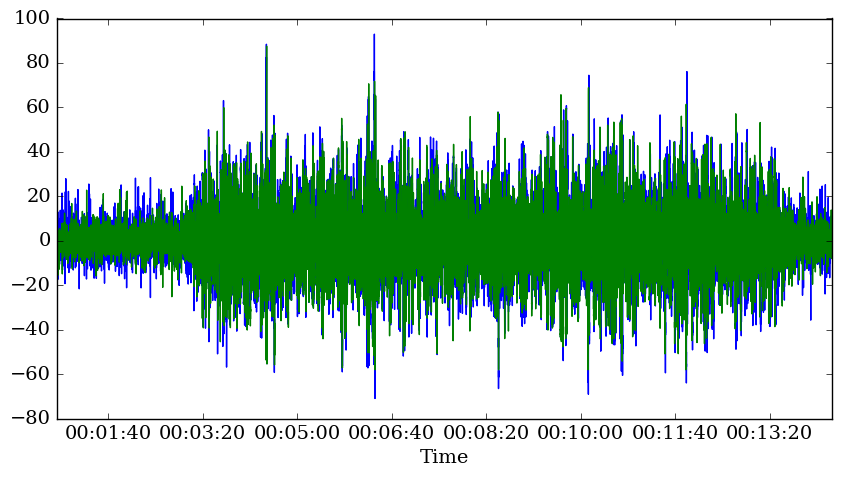

In [55]:
# Check initial stacked time-series comparison
df_all_inner['Wave_31m5'].plot()
df_all_inner['Wave_elev_31_5m'].plot()

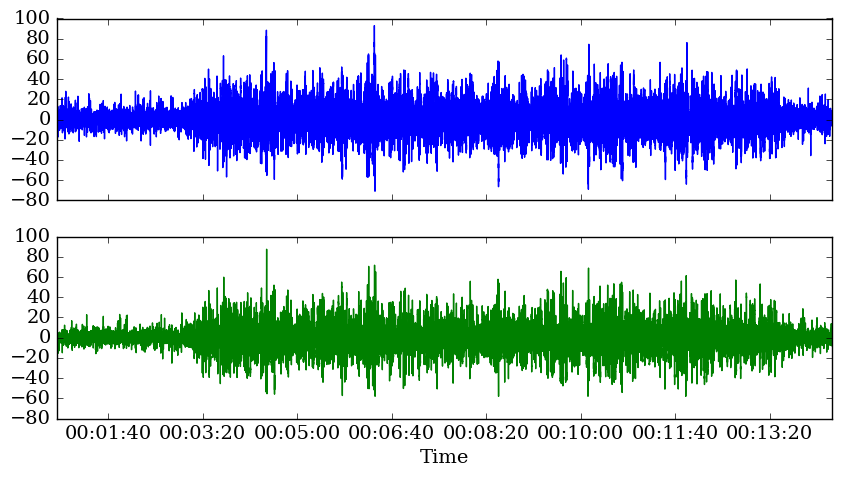

In [56]:
f, axarr = plt.subplots(2,1, sharex=True, sharey=True)

plt.sca(axarr[0])
df_all_inner['Wave_31m5'].plot()

plt.sca(axarr[1])
df_all_inner['Wave_elev_31_5m'].plot(c='g')

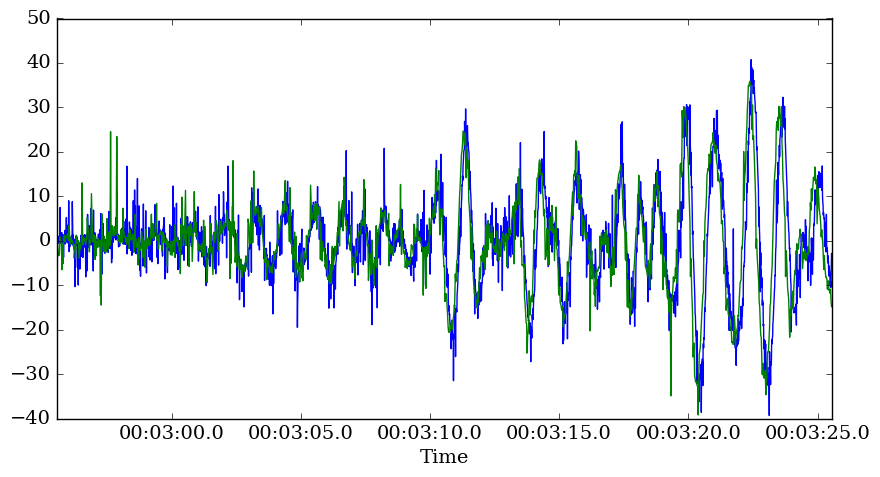

In [57]:
# Play with manual shifting at beginning
shift = -45
df_all_inner['Wave_31m5'].iloc[13000:16000].plot()
df_all_inner['Wave_elev_31_5m'].shift(shift).iloc[13000:16000].plot()

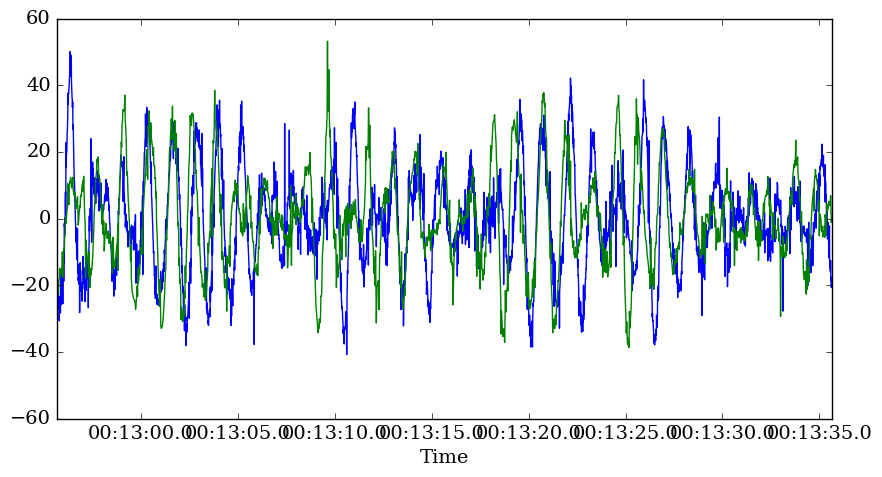

In [58]:
# Same shift at end
df_all_inner['Wave_31m5'].iloc[-9000:-5000].plot()
df_all_inner['Wave_elev_31_5m'].shift(shift).iloc[-9000:-5000].plot()

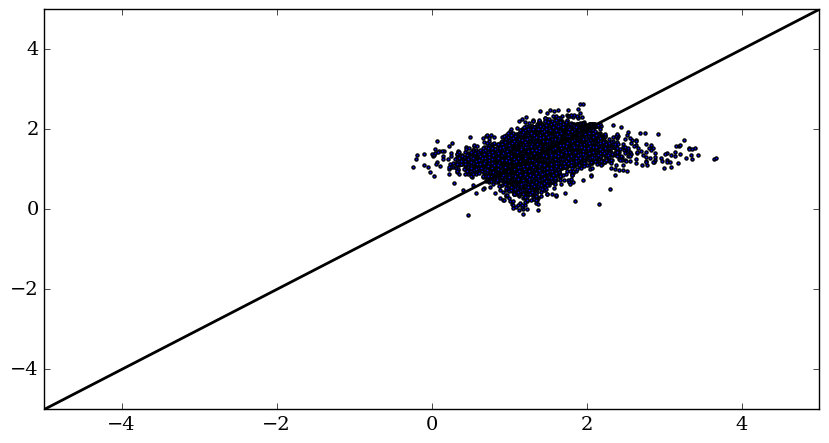

In [59]:
# Check result for wind sonic U component
plt.scatter(df_all_inner['WMPro_U'], df_all_inner['Sonic_U'], marker='.')
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.plot([-5,5], [-5,5], c='k', linewidth=2)

# Write results out to file

In [ ]:
# Write out master data in both HDF5 and TSV
df_all.to_hdf('.//output//all//'+filename+'_all'+'.hdf', key='df', mode='w', complib='blosc')
df_all.to_csv('.//output//all//'+filename+'_all'+'.tsv', sep='\t', header=True, decimal='.')

# Write out inner-joined data in both HDF5 and TSV
df_all_inner.to_hdf('.//output//inner//'+filename+'_inner'+'.hdf', key='df', mode='w', complib='blosc')
df_all_inner.to_csv('.//output//inner//'+filename+'_inner'+'.tsv', sep='\t', header=True, decimal='.')

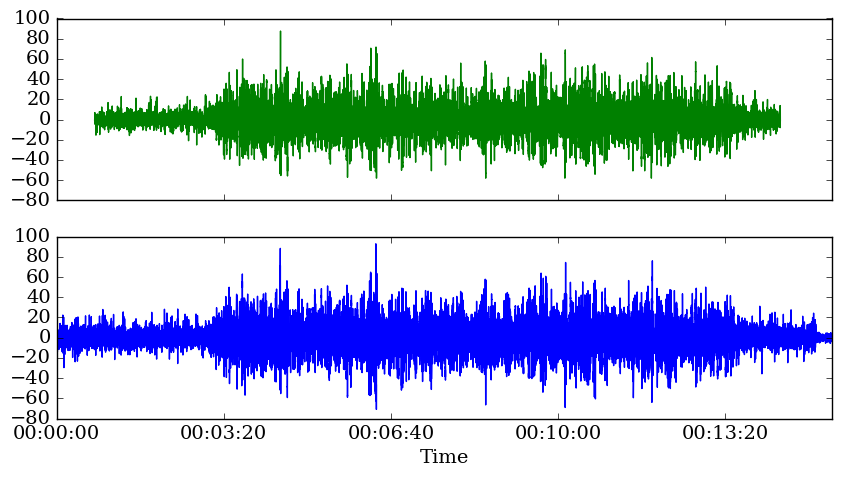

In [60]:
f, axarr = plt.subplots(2,1, sharex=True, sharey=True)

plt.sca(axarr[0])
df_all['Wave_elev_31_5m'].plot(c='g')

plt.sca(axarr[1])
df_all['Wave_31m5'].plot()

In [61]:
df_all.head()

,Mooring_starbord,Mooring_port,Mooring_aft,Surge_gauge,Side_gauge,Accelerometer,Wave_43m5,Wave_31m5,Wave_25m,Wave_paddle,...,DTU Yaw,DTU Pitch,DTU Roll,DTU Residual,GenVelocity,GenTorque,BladePitch,Sonic_U,Wave_elev_31_5m,RotSpeed
Time,,,,,,,,,,,,,,,,,,,,,
00:00:00,15.701026,0.124885,2.871793,0.054326,0.899108,12.809622,-0.234070,0.353412,-11.696763,0.061431,...,-0.11491,-0.00981,-0.03213,0.15693,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.010000,15.607521,0.289263,2.988681,0.810518,-0.503478,12.341154,0.499807,1.615850,-1.225329,0.041058,...,-0.11922,-0.01953,-0.01353,0.15315,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.020000,15.565393,0.269810,3.054105,0.657327,-0.378856,12.482121,0.470452,1.234182,-0.902680,0.115977,...,-0.11849,-0.01820,-0.01947,0.14059,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.030000,15.662802,0.354430,3.026602,-0.333157,-0.017372,12.337119,-0.351491,-1.143898,-0.404040,-0.012502,...,-0.11703,-0.01457,-0.02129,0.16209,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.040000,15.617797,0.294126,3.047646,0.368217,-0.679963,12.469543,-1.056012,-1.437489,-1.195997,0.037115,...,-0.12222,-0.01228,-0.03254,0.16534,NaN,NaN,NaN,NaN,NaN,NaN


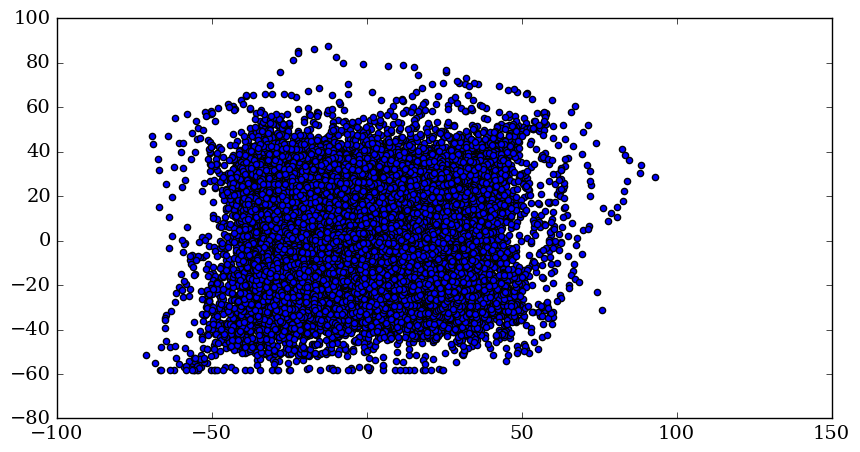

In [62]:
plt.scatter(df_all_inner['Wave_31m5'], df_all_inner['Wave_elev_31_5m'])

# Dynamic Time Warping

### Fast DTW

In [61]:
from fastdtw import fastdtw

In [ ]:
distance, path = fastdtw(df_all_inner['Wave_elev_31_5m'], df_all_inner['Wave_31m5'])

In [ ]:
distance

In [ ]:
len(path)

### DTW

In [63]:
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [64]:
def do_dtw(query, reference):
    alignment = dtw(query, reference, keep_internals=True, open_end=True)
    print('Distance = {0}'.format(alignment.distance))
    return alignment

In [65]:
# Define our reference (IFREMER data series) & query (DTU data series)

# Test on a portion due to large memory use
#n_min = 13000
#n_max = 16000

n_min = -9000
n_max = -5000

#query = df_dtu['Wave_elev_31_5m'].iloc[n_min:n_max]
#reference = df_ifremer['Wave_31m5'].iloc[n_min:n_max]

reference = df_all_inner['Wave_31m5'].iloc[n_min:n_max]
query = df_all_inner['Wave_elev_31_5m'].iloc[n_min:n_max]

#query = df_all_inner['Sonic_U'].iloc[n_min:n_max]
#reference = df_all_inner['WMPro_U'].iloc[n_min:n_max]

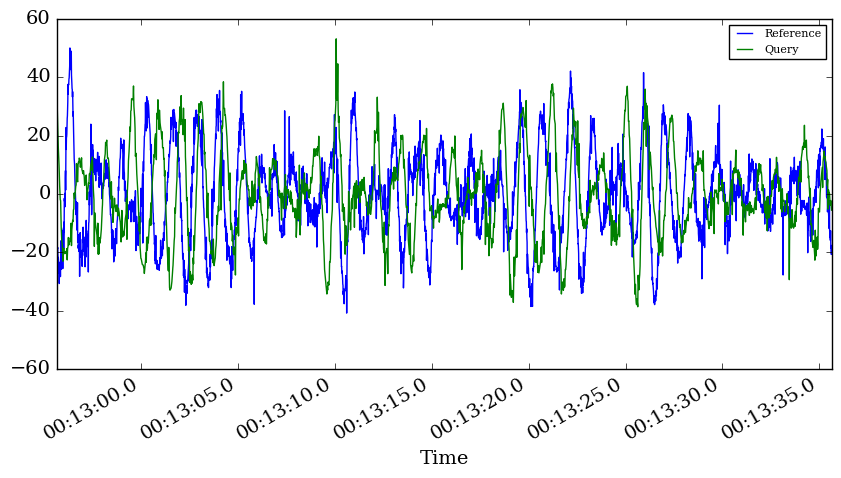

In [79]:
# Plot source data
reference.plot(label='Reference')
query.plot(label='Query')
plt.legend(fontsize=7)
plt.gcf().autofmt_xdate()

In [68]:
%%time
# Calculate the DTW and save results
alignment = do_dtw(query, reference)

Distance = 11281.874777189416
Wall time: 774 ms


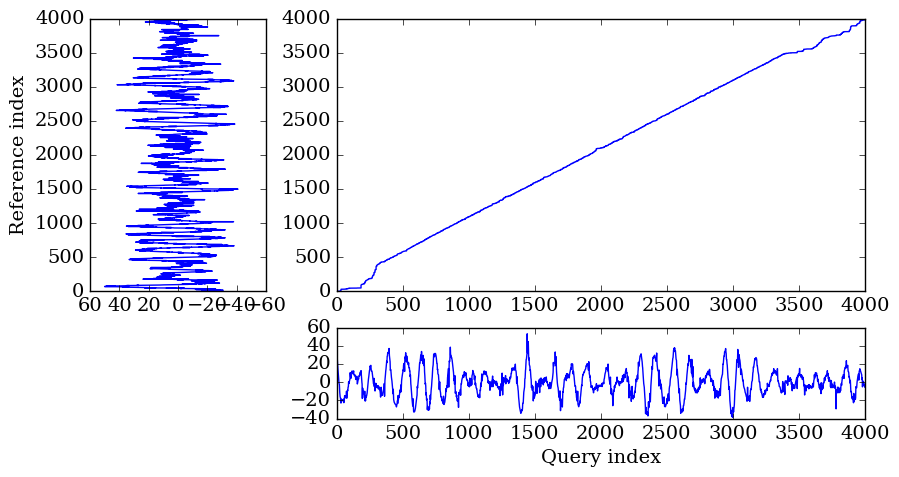

In [69]:
## Display the warping curve, i.e. alignment curve
alignment.plot(type="threeway")

In [ ]:
f,axarr = plt.subplots(3, sharey=True)

plt.sca(axarr[0])
alignment.reference.plot(c='r')
plt.title('Reference')
              
plt.sca(axarr[1])
plt.plot()
alignment.query.plot(c='b')
plt.title('Query')
              
plt.sca(axarr[2])
plt.plot(alignment.index2,query[alignment.index1], c='g')
plt.title('Warped Query')
plt.tight_layout()

In [70]:
# Calculate index series to apply warp function
wq = warp(alignment,index_reference=False)
wr = warp(alignment,index_reference=True)
#query[wq]

In [ ]:
f, axarr = plt.subplots(2,1, sharex=True)
plt.sca(axarr[0])
plt.plot(reference)
plt.plot(query[wq])
plt.gca().set_title("Warping query")

plt.sca(axarr[1])
plt.plot(query)
plt.plot(reference[wr])
plt.gca().set_title("Warping reference")

In [71]:
# Build warped time-series from query data and reference index
df_warped = pd.DataFrame(query[alignment.index1].values, index=alignment.index2, columns=['Query'])
# Merge duplicated index values
df_warped = df_warped.groupby(df_warped.index).mean()

In [72]:
df_warped.head()

,Query
0,11.491173
1,-15.638520
2,-16.821282
3,-16.977495
4,-18.450368


In [73]:
# Set index of warped query to reference index
df_warped.set_index(reference.iloc[0:len(df_warped)].index, inplace=True)

In [74]:
# Join warped query and reference series together, and drop NaNs
df_result = pd.DataFrame(reference.rename('Reference')).join(df_warped)
df_result_nona = df_result.dropna(how='any')

In [75]:
df_result

,Reference,Query
Time,,
00:12:55.640000,-12.564557,11.491173
00:12:55.650000,-15.705972,-15.638520
00:12:55.660000,-16.762897,-16.821282
00:12:55.670000,-17.438155,-16.977495
00:12:55.680000,-18.377643,-18.450368
...,...,...
00:13:35.590000,-16.939051,NaN
00:13:35.600000,-18.553797,NaN
00:13:35.610000,-18.201489,NaN


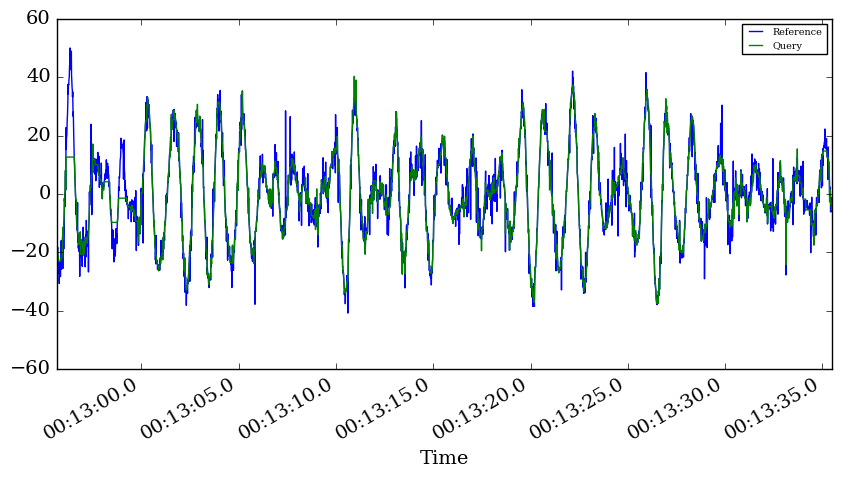

In [80]:
# Check result
df_result_nona['Reference'].plot()
df_result_nona['Query'].plot()
plt.legend(fontsize=7)
plt.gcf().autofmt_xdate()

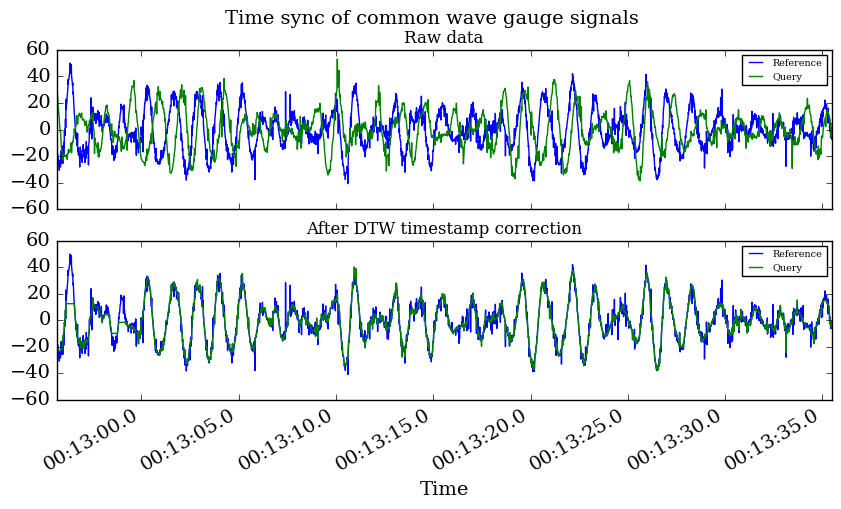

In [111]:
f,axarr = plt.subplots(2,1, sharex=True)
plt.suptitle('Time sync of common wave gauge signals')
plt.sca(axarr[0])

plt.title('Raw data', fontsize=12)
reference.plot(label='Reference')
query.plot(label='Query')
plt.legend(fontsize=7)
plt.gcf().autofmt_xdate()

plt.sca(axarr[1])

plt.title('After DTW timestamp correction', fontsize=12)
df_result_nona['Reference'].plot()
df_result_nona['Query'].plot()
plt.legend(fontsize=7)
plt.gcf().autofmt_xdate()

#plt.sca(axarr[2])
#plt.plot(alignment.index1, alignment.index2)

plt.gcf().savefig('dtw_sync.png', dpi=100, bbox_inches='tight')